<a href="https://colab.research.google.com/github/musman2012/ml-data_science/blob/master/SOH_Prediction/Phase_II_ML_Bayes_Binning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Phase-II
This phase would have the following keys steps to perform:
* Apply labelling/binning on the data (yet to decided the technique)
* Make three clusters/subsets of the data on the basis of cycle variable
* Apply Association Rule Mining on the subsets
* Apply prediction technique to classify the target variable soh
* Evaluate Models Results

More explanation for the process and what I want to acheive 

In [3]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import platform
import dill
dill.load_session('phase-II-ml-copy.db')

FileNotFoundError: ignored

In [5]:
'''
authored by Muhammad Usman (musman14@student.bradford.ac.uk)

!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

FILE_PATH = "batteries_processed.csv"
bat_data = pd.read_csv(FILE_PATH, error_bad_lines = False)    # reading the data from csv file

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Removing the same features which were removed in Phase-I as well

In [11]:
filtered_data = bat_data.copy()
columns_to_drop = ['id', 'vin', 'vin_prefix', 'record_id','recorded_time', 'actual_time', 'arrival_time', 'powermode', 'mheader_vin', 'mheader_time', 'mheader_type', 'message','cat4', 'cat6', 'cat7', 'inlet_coolant_temp','cooling_energy_used', 'max_soh_cell', 'fuse_temp', 'power_soh', 'min_soh', 'max_soh', 'min_soh_cell_id','imbalance_percent', 'parkingdata_hvbattavgsocoatevent', 'parkingdata_hvbattavtempatevent']
filtered_data = filtered_data.drop(columns=columns_to_drop)
filtered_data.head()

,odometer,ambient_temp,vehicle_speed,balancing_trigger_cell,balancing_status,min_voltage,min_temp,traction_current,max_voltage,imbalance,traction_voltage,min_temp_cell,min_voltage_cell,max_voltage_cell,max_temp,max_temp_cell,emodule_temp,thermal_manager_mode,outlet_coolant_temp,soh,fast_charge_count,cycle,num_cycle,fast_charge,trip_distance
0,10619,6.5,0.0,22,noBalancing,4.107,12,0.675,4.153,0.046,445,15,22,96,14,1,135,activeHeating,195,98.0,0,storage,1,False,0
1,9531,4.0,0.0,22,noBalancing,3.983,6,7.375,4.008,0.025,432,16,36,21,7,1,90,idle,55,98.0,0,storage,1,False,-1088
2,9531,4.0,0.0,22,noBalancing,3.989,6,7.600,4.023,0.034,431,16,36,76,7,1,90,idle,55,98.0,0,storage,1,False,0
3,9531,4.0,0.0,22,noBalancing,3.984,6,6.850,4.020,0.036,431,16,36,79,7,1,90,idle,55,98.0,0,storage,1,False,0
4,9531,4.0,0.0,22,noBalancing,3.980,6,7.000,4.015,0.035,431,16,36,85,7,1,90,idle,55,98.0,0,storage,1,False,0


In [0]:
for c in filtered_data.columns:
  print("Column", c)
  print(filtered_data[c].value_counts(normalize='true'))

Column odometer
6923     3.802000e-04
3297     3.316000e-04
2739     3.222000e-04
3296     3.138000e-04
703      3.076000e-04
             ...     
17205    2.000000e-07
20739    2.000000e-07
29491    2.000000e-07
23197    2.000000e-07
21109    2.000000e-07
Name: odometer, Length: 23959, dtype: float64
Column ambient_temp
 9.25     3.626360e-02
 8.75     3.488080e-02
 8.25     3.181080e-02
 7.75     3.039420e-02
 9.75     2.789920e-02
              ...     
-20.50    2.000000e-07
-20.25    2.000000e-07
-21.50    2.000000e-07
-21.00    2.000000e-07
 43.50    2.000000e-07
Name: ambient_temp, Length: 266, dtype: float64
Column vehicle_speed
0.00      8.465960e-01
114.52    3.068000e-04
98.94     2.968000e-04
104.79    2.930000e-04
0.73      2.876000e-04
              ...     
168.86    2.000000e-07
162.22    2.000000e-07
154.74    2.000000e-07
163.91    2.000000e-07
165.31    2.000000e-07
Name: vehicle_speed, Length: 3037, dtype: float64
Column balancing_trigger_cell
49     0.024991
76   

In [7]:
float_cols

,ambient_temp,vehicle_speed,min_voltage,traction_current,max_voltage,imbalance,soh
0,6.50,0.0,4.107,0.675,4.153,0.046,98.0
1,4.00,0.0,3.983,7.375,4.008,0.025,98.0
2,4.00,0.0,3.989,7.600,4.023,0.034,98.0
3,4.00,0.0,3.984,6.850,4.020,0.036,98.0
4,4.00,0.0,3.980,7.000,4.015,0.035,98.0
...,...,...,...,...,...,...,...
4999995,9.75,0.0,4.123,-3.550,4.140,0.017,98.0
4999996,9.75,0.0,4.123,-2.925,4.139,0.016,98.0
4999997,9.75,0.0,4.123,-3.425,4.140,0.017,98.0
4999998,9.75,0.0,4.124,-3.400,4.140,0.016,98.0


### Binning the data
We have to choices for Binning the data here:
* Fixed-Width Binning: Specific fixed widths for each of the bins which are usually pre-defined
* Adaptive Binning: Such binning in which we use the data distribution itself to decide bin ranges

&rightarrow; Quantile Binning is one of the type of Adaptive Binning which helps in partitioning the continuous valued distribution of a specific numeric field into discrete contiguous bins or intervals. We will use this binning to convert out continuous variables into categorical variables.

In [12]:
int_cols = filtered_data.select_dtypes('int64') ## finding all the continuous variables
float_cols = filtered_data.select_dtypes('float')
categ_data = pd.DataFrame()
int_cols = int_cols.loc[:, int_cols.nunique() > 4]
float_cols = float_cols.loc[:, float_cols.nunique() > 4]
float_cols = float_cols.drop(columns=['soh'])

## try fuzzy binning on the SOH
## print the boundaries as well
boundaries = dict()
for col in int_cols.columns:
  print("Col in progress is ", col)
  filtered_data[col], boundaries[col] = pd.qcut(filtered_data[col], 4,duplicates='drop', labels=False, retbins=True)
print("Int Cols Now")
for col in float_cols.columns:
  print("Col in progress is ", col)
  filtered_data[col], boundaries[col] = pd.qcut(filtered_data[col], 4, duplicates='drop', labels=False, retbins=True)
filtered_data.head()

Col in progress is  odometer
Col in progress is  balancing_trigger_cell
Col in progress is  min_temp
Col in progress is  traction_voltage
Col in progress is  min_temp_cell
Col in progress is  min_voltage_cell
Col in progress is  max_voltage_cell
Col in progress is  max_temp
Col in progress is  max_temp_cell
Col in progress is  emodule_temp
Col in progress is  outlet_coolant_temp
Col in progress is  fast_charge_count
Col in progress is  num_cycle
Col in progress is  trip_distance
Int Cols Now
Col in progress is  ambient_temp
Col in progress is  vehicle_speed
Col in progress is  min_voltage
Col in progress is  traction_current
Col in progress is  max_voltage
Col in progress is  imbalance


,odometer,ambient_temp,vehicle_speed,balancing_trigger_cell,balancing_status,min_voltage,min_temp,traction_current,max_voltage,imbalance,traction_voltage,min_temp_cell,min_voltage_cell,max_voltage_cell,max_temp,max_temp_cell,emodule_temp,thermal_manager_mode,outlet_coolant_temp,soh,fast_charge_count,cycle,num_cycle,fast_charge,trip_distance
0,3,1,0,0,noBalancing,3,1,3,3,3,3,1,0,3,1,0,0,activeHeating,3,98.0,0,storage,0,False,0
1,3,0,0,0,noBalancing,2,0,3,2,2,2,1,1,1,0,0,0,idle,0,98.0,0,storage,0,False,0
2,3,0,0,0,noBalancing,2,0,3,2,3,2,1,1,3,0,0,0,idle,0,98.0,0,storage,0,False,0
3,3,0,0,0,noBalancing,2,0,3,2,3,2,1,1,3,0,0,0,idle,0,98.0,0,storage,0,False,0
4,3,0,0,0,noBalancing,2,0,3,2,3,2,1,1,3,0,0,0,idle,0,98.0,0,storage,0,False,0


In [0]:
## This output will show the boundary cut for binning
## the output should be read in the following way e.g. for [     0.   2813.   5412.   8233. 142256.]
## 0. to  2813. --> Low
## 2813. to 5412. --> Medium
## 5412. to  8233. --> High
## 8233. to 142256. --> Very High
for col in boundaries:
  print(col)
  print(boundaries[col])

odometer
[     0.   2813.   5412.   8233. 142256.]
balancing_trigger_cell
[  0.  28.  54.  79. 108.]
min_temp
[-40.  11.  13.  15.  51.]
traction_voltage
[  0. 406. 422. 435. 450.]
min_temp_cell
[  1.  10.  18. 108.]
min_voltage_cell
[  1.  23.  49.  76. 108.]
max_voltage_cell
[  1.  20.  43.  70. 108.]
max_temp
[-40.  12.  14.  17.  55.]
max_temp_cell
[  1.  16. 108.]
emodule_temp
[-150.  190.  230.  260.  875.]
outlet_coolant_temp
[-160.  100.  125.  145.  870.]
fast_charge_count
[  0. 200.]
num_cycle
[  1.   5.  11.  19. 247.]
trip_distance
[-52788.      0.  52790.]
ambient_temp
[-128.      6.25    9.     11.5    46.5 ]
vehicle_speed
[  0.   200.13]
min_voltage
[0.    3.744 3.894 4.018 4.155]
traction_current
[-2.09715175e+05 -9.20000000e+00 -6.42500000e+00 -9.50000000e-01
  2.09715200e+05]
max_voltage
[0.    3.768 3.918 4.043 4.183]
imbalance
[-0.02   0.012  0.017  0.026  1.141]
soh
[  0.  98. 100.]


In [13]:
soh_boundaries = [  0.,    68.25,  84.25,  98.05, 100.  ]
labelled_soh = []
#count = 0
for val in filtered_data['soh']:
  if soh_boundaries[1] > val >= soh_boundaries[0]:
    labelled_soh.append(0)
  elif soh_boundaries[2] > val:
    labelled_soh.append(1)
  elif soh_boundaries[3] > val:
    labelled_soh.append(2)
  else:
    labelled_soh.append(3)
  #count += 1
filtered_data.insert(loc=len(filtered_data.columns), column='new_soh', value=labelled_soh)
filtered_data.head()

,odometer,ambient_temp,vehicle_speed,balancing_trigger_cell,balancing_status,min_voltage,min_temp,traction_current,max_voltage,imbalance,traction_voltage,min_temp_cell,min_voltage_cell,max_voltage_cell,max_temp,max_temp_cell,emodule_temp,thermal_manager_mode,outlet_coolant_temp,soh,fast_charge_count,cycle,num_cycle,fast_charge,trip_distance,new_soh
0,3,1,0,0,noBalancing,3,1,3,3,3,3,1,0,3,1,0,0,activeHeating,3,98.0,0,storage,0,False,0,2
1,3,0,0,0,noBalancing,2,0,3,2,2,2,1,1,1,0,0,0,idle,0,98.0,0,storage,0,False,0,2
2,3,0,0,0,noBalancing,2,0,3,2,3,2,1,1,3,0,0,0,idle,0,98.0,0,storage,0,False,0,2
3,3,0,0,0,noBalancing,2,0,3,2,3,2,1,1,3,0,0,0,idle,0,98.0,0,storage,0,False,0,2
4,3,0,0,0,noBalancing,2,0,3,2,3,2,1,1,3,0,0,0,idle,0,98.0,0,storage,0,False,0,2


In [14]:
filtered_data = filtered_data.drop(columns=['soh'])
filtered_data.head()

,odometer,ambient_temp,vehicle_speed,balancing_trigger_cell,balancing_status,min_voltage,min_temp,traction_current,max_voltage,imbalance,traction_voltage,min_temp_cell,min_voltage_cell,max_voltage_cell,max_temp,max_temp_cell,emodule_temp,thermal_manager_mode,outlet_coolant_temp,fast_charge_count,cycle,num_cycle,fast_charge,trip_distance,new_soh
0,3,1,0,0,noBalancing,3,1,3,3,3,3,1,0,3,1,0,0,activeHeating,3,0,storage,0,False,0,2
1,3,0,0,0,noBalancing,2,0,3,2,2,2,1,1,1,0,0,0,idle,0,0,storage,0,False,0,2
2,3,0,0,0,noBalancing,2,0,3,2,3,2,1,1,3,0,0,0,idle,0,0,storage,0,False,0,2
3,3,0,0,0,noBalancing,2,0,3,2,3,2,1,1,3,0,0,0,idle,0,0,storage,0,False,0,2
4,3,0,0,0,noBalancing,2,0,3,2,3,2,1,1,3,0,0,0,idle,0,0,storage,0,False,0,2


In [10]:
#d = {0 : 'Low', 1 : 'Medium', 2 : 'High', 3 : 'Very_High'}
d1 = { 'noBalancing' : 0, 'passiveBalancing' : 1, 'initialValue' : 2}
d2 = {'idle' : 0, 'activeHeating' : 1, 'passingCooling' : 2, 'thermalBalancing' : 3,
      'initialValue' : 4, 'activeCooling' : 5 }
#for c in float_cols.columns:
filtered_data['balancing_status'] = filtered_data['balancing_status'].map(d1)
#for c in int_cols.columns:
filtered_data['balancing_status'] = filtered_data['balancing_status'].map(d2)
filtered_data.head()

,odometer,ambient_temp,vehicle_speed,balancing_trigger_cell,balancing_status,min_voltage,min_temp,traction_current,max_voltage,imbalance,traction_voltage,min_temp_cell,min_voltage_cell,max_voltage_cell,max_temp,max_temp_cell,emodule_temp,thermal_manager_mode,outlet_coolant_temp,fast_charge_count,cycle,num_cycle,fast_charge,trip_distance,new_soh
0,3,1,0,0,NaN,3,1,3,3,3,3,1,0,3,1,0,0,activeHeating,3,0,storage,0,False,0,2
1,3,0,0,0,NaN,2,0,3,2,2,2,1,1,1,0,0,0,idle,0,0,storage,0,False,0,2
2,3,0,0,0,NaN,2,0,3,2,3,2,1,1,3,0,0,0,idle,0,0,storage,0,False,0,2
3,3,0,0,0,NaN,2,0,3,2,3,2,1,1,3,0,0,0,idle,0,0,storage,0,False,0,2
4,3,0,0,0,NaN,2,0,3,2,3,2,1,1,3,0,0,0,idle,0,0,storage,0,False,0,2


In [0]:
encoded_data = pd.get_dummies(filtered_data)
encoded_data.head()

,fast_charge,odometer_High,odometer_Low,odometer_Medium,odometer_Very_High,ambient_temp_High,ambient_temp_Low,ambient_temp_Medium,ambient_temp_Very_High,vehicle_speed_Low,balancing_trigger_cell_High,balancing_trigger_cell_Low,balancing_trigger_cell_Medium,balancing_trigger_cell_Very_High,balancing_status_initialValue,balancing_status_noBalancing,balancing_status_passiveBalancing,min_voltage_High,min_voltage_Low,min_voltage_Medium,min_voltage_Very_High,min_temp_High,min_temp_Low,min_temp_Medium,min_temp_Very_High,traction_current_High,traction_current_Low,traction_current_Medium,traction_current_Very_High,max_voltage_High,max_voltage_Low,max_voltage_Medium,max_voltage_Very_High,imbalance_High,imbalance_Low,imbalance_Medium,imbalance_Very_High,traction_voltage_High,traction_voltage_Low,traction_voltage_Medium,...,min_voltage_cell_High,min_voltage_cell_Low,min_voltage_cell_Medium,min_voltage_cell_Very_High,max_voltage_cell_High,max_voltage_cell_Low,max_voltage_cell_Medium,max_voltage_cell_Very_High,max_temp_High,max_temp_Low,max_temp_Medium,max_temp_Very_High,max_temp_cell_Low,max_temp_cell_Medium,emodule_temp_High,emodule_temp_Low,emodule_temp_Medium,emodule_temp_Very_High,thermal_manager_mode_activeCooling,thermal_manager_mode_activeHeating,thermal_manager_mode_idle,thermal_manager_mode_initialValue,thermal_manager_mode_passingCooling,thermal_manager_mode_thermalBalancing,outlet_coolant_temp_High,outlet_coolant_temp_Low,outlet_coolant_temp_Medium,outlet_coolant_temp_Very_High,soh_Low,soh_Medium,fast_charge_count_Low,cycle_charge,cycle_drive,cycle_storage,num_cycle_High,num_cycle_Low,num_cycle_Medium,num_cycle_Very_High,trip_distance_Low,trip_distance_Medium
0,False,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0
1,False,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0
2,False,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0
3,False,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0
4,False,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0


In [0]:
#filtered_data = filtered_data.drop(columns=['fuse_temp'])
for c in filtered_data.columns:
  print("Column", c)
  print(filtered_data[c].value_counts(normalize='true'))

Column odometer
0    0.250068
1    0.250000
3    0.249968
2    0.249964
Name: odometer, dtype: float64
Column ambient_temp
0    0.270383
2    0.247501
3    0.241288
1    0.240828
Name: ambient_temp, dtype: float64
Column vehicle_speed
0    1.0
Name: vehicle_speed, dtype: float64
Column balancing_trigger_cell
2    0.256329
0    0.252668
1    0.248518
3    0.242485
Name: balancing_trigger_cell, dtype: float64
Column balancing_status
noBalancing         0.714526
passiveBalancing    0.285253
initialValue        0.000221
Name: balancing_status, dtype: float64
Column min_voltage
0    0.250488
1    0.250466
2    0.249558
3    0.249488
Name: min_voltage, dtype: float64
Column min_temp
0    0.317571
1    0.229993
3    0.228385
2    0.224050
Name: min_temp, dtype: float64
Column traction_current
0    0.250455
3    0.249992
2    0.249890
1    0.249662
Name: traction_current, dtype: float64
Column max_voltage
0    0.251233
2    0.249916
1    0.249685
3    0.249167
Name: max_voltage, dtype: float64

### Creating subsets of the data on the basis of cycle variable

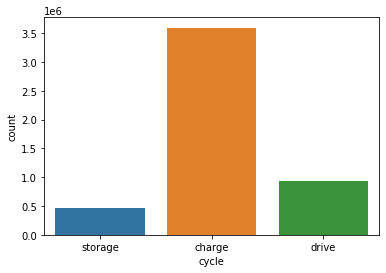

In [0]:
sns.countplot(filtered_data['cycle'])

In [0]:
bat_storage_data = filtered_data[bat_data['cycle'] == 'storage']
bat_charge_data = filtered_data[bat_data['cycle'] == 'charge']
bat_drive_data = filtered_data[bat_data['cycle'] == 'drive']
print("storage data dimensions are ", bat_storage_data.shape)
print("charge data dimensions are ", bat_charge_data.shape)
print("drive data dimensions are ", bat_drive_data.shape)

storage data dimensions are  (467495, 25)
charge data dimensions are  (3595456, 25)
drive data dimensions are  (937049, 25)


#### Encoding the data to apply Association rule Mining

In [0]:
encoded_storage = pd.get_dummies(bat_storage_data)
encoded_charge = pd.get_dummies(bat_charge_data)
encoded_drive = pd.get_dummies(bat_drive_data)

In [0]:
encoded_storage.head()

,fast_charge,odometer_High,odometer_Low,odometer_Medium,odometer_Very_High,ambient_temp_High,ambient_temp_Low,ambient_temp_Medium,ambient_temp_Very_High,vehicle_speed_Low,balancing_trigger_cell_High,balancing_trigger_cell_Low,balancing_trigger_cell_Medium,balancing_trigger_cell_Very_High,balancing_status_initialValue,balancing_status_noBalancing,balancing_status_passiveBalancing,min_voltage_High,min_voltage_Low,min_voltage_Medium,min_voltage_Very_High,min_temp_High,min_temp_Low,min_temp_Medium,min_temp_Very_High,traction_current_High,traction_current_Low,traction_current_Medium,traction_current_Very_High,max_voltage_High,max_voltage_Low,max_voltage_Medium,max_voltage_Very_High,imbalance_High,imbalance_Low,imbalance_Medium,imbalance_Very_High,traction_voltage_High,traction_voltage_Low,traction_voltage_Medium,...,min_temp_cell_Low,min_temp_cell_Medium,min_voltage_cell_High,min_voltage_cell_Low,min_voltage_cell_Medium,min_voltage_cell_Very_High,max_voltage_cell_High,max_voltage_cell_Low,max_voltage_cell_Medium,max_voltage_cell_Very_High,max_temp_High,max_temp_Low,max_temp_Medium,max_temp_Very_High,max_temp_cell_Low,max_temp_cell_Medium,emodule_temp_High,emodule_temp_Low,emodule_temp_Medium,emodule_temp_Very_High,thermal_manager_mode_activeCooling,thermal_manager_mode_activeHeating,thermal_manager_mode_idle,thermal_manager_mode_initialValue,thermal_manager_mode_passingCooling,thermal_manager_mode_thermalBalancing,outlet_coolant_temp_High,outlet_coolant_temp_Low,outlet_coolant_temp_Medium,outlet_coolant_temp_Very_High,soh_Low,soh_Medium,fast_charge_count_Low,cycle_storage,num_cycle_High,num_cycle_Low,num_cycle_Medium,num_cycle_Very_High,trip_distance_Low,trip_distance_Medium
0,False,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,1,0,0,1,0
1,False,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,1,0
2,False,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,...,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,1,0
3,False,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,...,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,1,0
4,False,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,...,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,1,0


### Applying Association Rule Mining

In [0]:
from mlxtend.frequent_patterns import apriori, association_rules

In [0]:
#association_rules = apriori(filtered_data, min_support=0.005)
#association_results = list(association_rules)


arm = apriori(encoded_data,min_support = 0.6, use_colnames = True) 

assoc_rules = association_rules(arm, metric ="confidence", min_threshold = 0.8) 
assoc_rules = assoc_rules.sort_values(['confidence', 'lift']) 

In [0]:
arm_storage = apriori(encoded_storage, min_support = 0.6, use_colnames = True) 

assoc_rules_storage = association_rules(arm_storage, metric ="confidence", min_threshold = 0.8) 
assoc_rules_storage = assoc_rules_storage.sort_values(['confidence', 'lift'])

In [0]:
arm_charge = apriori(encoded_charge, min_support = 0.6, use_colnames = True) 

assoc_rules_charge = association_rules(arm_charge, metric ="confidence", min_threshold = 0.8) 
assoc_rules_charge = assoc_rules_charge.sort_values(['confidence', 'lift'])

In [0]:
arm_drive = apriori(encoded_drive, min_support = 0.6, use_colnames = True) 

assoc_rules_drive = association_rules(arm_drive, metric ="confidence", min_threshold = 0.8) 
assoc_rules_drive = assoc_rules_drive.sort_values(['confidence', 'lift'])

In [0]:
#assoc_rules
assoc_rules["antecedent_len"] = assoc_rules["antecedents"].apply(lambda x: len(x))
assoc_rules[ (assoc_rules['antecedent_len'] >= 3) &
       (assoc_rules['confidence'] > 0.75)  ]

There was no rule with State of Health Low or High in the consequents but there were some rules with soh_Low in the antecedents.

In [0]:
assoc_rules_charge[(assoc_rules_charge['confidence'] > 0.75) & (assoc_rules_charge['antecedents'] == {'soh_Low'})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
21,(soh_Low),(trip_distance_Low),0.785188,0.990161,0.777293,0.989944,0.999781,-0.00017,0.978408
63,(soh_Low),"(trip_distance_Low, vehicle_speed_Low)",0.785188,0.990161,0.777293,0.989944,0.999781,-0.00017,0.978408
114,(soh_Low),"(fast_charge_count_Low, trip_distance_Low)",0.785188,0.990161,0.777293,0.989944,0.999781,-0.00017,0.978408
117,(soh_Low),"(cycle_charge, trip_distance_Low)",0.785188,0.990161,0.777293,0.989944,0.999781,-0.00017,0.978408
200,(soh_Low),"(fast_charge_count_Low, trip_distance_Low, veh...",0.785188,0.990161,0.777293,0.989944,0.999781,-0.00017,0.978408
207,(soh_Low),"(cycle_charge, trip_distance_Low, vehicle_spee...",0.785188,0.990161,0.777293,0.989944,0.999781,-0.00017,0.978408
249,(soh_Low),"(fast_charge_count_Low, cycle_charge, trip_dis...",0.785188,0.990161,0.777293,0.989944,0.999781,-0.00017,0.978408
309,(soh_Low),"(fast_charge_count_Low, cycle_charge, trip_dis...",0.785188,0.990161,0.777293,0.989944,0.999781,-0.00017,0.978408
3,(soh_Low),(vehicle_speed_Low),0.785188,1.000000,0.785188,1.000000,1.000000,0.00000,inf
19,(soh_Low),(fast_charge_count_Low),0.785188,1.000000,0.785188,1.000000,1.000000,0.00000,inf


In [0]:
assoc_rules_drive[(assoc_rules_drive['confidence'] > 0.75) & (assoc_rules_drive['antecedents'] == {'soh_Low'})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
19,(soh_Low),(traction_current_Very_High),0.79423,0.801761,0.636289,0.801140,0.999226,-0.000493,0.996879
61,(soh_Low),"(traction_current_Very_High, vehicle_speed_Low)",0.79423,0.801761,0.636289,0.801140,0.999226,-0.000493,0.996879
159,(soh_Low),"(fast_charge_count_Low, traction_current_Very_...",0.79423,0.801761,0.636289,0.801140,0.999226,-0.000493,0.996879
162,(soh_Low),"(traction_current_Very_High, cycle_drive)",0.79423,0.801761,0.636289,0.801140,0.999226,-0.000493,0.996879
309,(soh_Low),"(fast_charge_count_Low, traction_current_Very_...",0.79423,0.801761,0.636289,0.801140,0.999226,-0.000493,0.996879
316,(soh_Low),"(traction_current_Very_High, vehicle_speed_Low...",0.79423,0.801761,0.636289,0.801140,0.999226,-0.000493,0.996879
485,(soh_Low),"(fast_charge_count_Low, traction_current_Very_...",0.79423,0.801761,0.636289,0.801140,0.999226,-0.000493,0.996879
702,(soh_Low),"(fast_charge_count_Low, traction_current_Very_...",0.79423,0.801761,0.636289,0.801140,0.999226,-0.000493,0.996879
27,(soh_Low),(thermal_manager_mode_idle),0.79423,0.975297,0.774022,0.974558,0.999242,-0.000587,0.970944
86,(soh_Low),"(thermal_manager_mode_idle, vehicle_speed_Low)",0.79423,0.975297,0.774022,0.974558,0.999242,-0.000587,0.970944


In [0]:
assoc_rules_storage[(assoc_rules_storage['confidence'] > 0.75) & (assoc_rules_storage['antecedents'] == {'soh_Low'})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
785,(soh_Low),"(thermal_manager_mode_idle, traction_current_V...",0.76317,0.853275,0.644013,0.843866,0.988973,-0.007181,0.939738
1217,(soh_Low),"(trip_distance_Low, thermal_manager_mode_idle,...",0.76317,0.853275,0.644013,0.843866,0.988973,-0.007181,0.939738
1697,(soh_Low),"(fast_charge_count_Low, thermal_manager_mode_i...",0.76317,0.853275,0.644013,0.843866,0.988973,-0.007181,0.939738
1712,(soh_Low),"(thermal_manager_mode_idle, traction_current_V...",0.76317,0.853275,0.644013,0.843866,0.988973,-0.007181,0.939738
2128,(soh_Low),"(thermal_manager_mode_idle, traction_current_V...",0.76317,0.853275,0.644013,0.843866,0.988973,-0.007181,0.939738
...,...,...,...,...,...,...,...,...,...
40,(soh_Low),(cycle_storage),0.76317,1.000000,0.763170,1.000000,1.000000,0.000000,inf
128,(soh_Low),"(fast_charge_count_Low, vehicle_speed_Low)",0.76317,1.000000,0.763170,1.000000,1.000000,0.000000,inf
131,(soh_Low),"(vehicle_speed_Low, cycle_storage)",0.76317,1.000000,0.763170,1.000000,1.000000,0.000000,inf
290,(soh_Low),"(fast_charge_count_Low, cycle_storage)",0.76317,1.000000,0.763170,1.000000,1.000000,0.000000,inf


### ARM on the complete Encoded Dataset

In [0]:
#assoc_rules["antecedent_len"] = assoc_rules["antecedents"].apply(lambda x: len(x))
assoc_rules[(assoc_rules['confidence'] > 0.75) & (assoc_rules['antecedents'] == {'soh_Low'})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
13,(soh_Low),(trip_distance_Low),0.784824,0.903743,0.708462,0.902702,0.998848,-0.000817,0.9893,1
35,(soh_Low),"(vehicle_speed_Low, trip_distance_Low)",0.784824,0.903743,0.708462,0.902702,0.998848,-0.000817,0.9893,1
56,(soh_Low),"(trip_distance_Low, fast_charge_count_Low)",0.784824,0.903743,0.708462,0.902702,0.998848,-0.000817,0.9893,1
80,(soh_Low),"(vehicle_speed_Low, trip_distance_Low, fast_ch...",0.784824,0.903743,0.708462,0.902702,0.998848,-0.000817,0.9893,1
2,(soh_Low),(vehicle_speed_Low),0.784824,1.000000,0.784824,1.000000,1.000000,0.000000,inf,1
12,(soh_Low),(fast_charge_count_Low),0.784824,1.000000,0.784824,1.000000,1.000000,0.000000,inf,1
32,(soh_Low),"(vehicle_speed_Low, fast_charge_count_Low)",0.784824,1.000000,0.784824,1.000000,1.000000,0.000000,inf,1


### Further subsets of each of the cycle - W.R.T State of Health

In [0]:
encoded_storage_sh = encoded_storage[encoded_storage['soh_Medium'] == 1]
encoded_storage_sl = encoded_storage[encoded_storage['soh_Low'] == 1]

In [0]:
arm_storage_high = apriori(encoded_storage_sh, min_support = 0.6, use_colnames = True) 

assoc_rules_storage_high = association_rules(arm_storage_high, metric ="confidence", min_threshold = 0.8) 
assoc_rules_storage_high = assoc_rules_storage_high.sort_values(['confidence', 'lift'])

arm_storage_low = apriori(encoded_storage_sl, min_support = 0.6, use_colnames = True) 

assoc_rules_storage_low = association_rules(arm_storage_low, metric ="confidence", min_threshold = 0.8) 
assoc_rules_storage_low = assoc_rules_storage_low.sort_values(['confidence', 'lift'])

The following rules are extracted from the storage cycle dataset of the complete data. Support, Confidence, and Lift are three of the most important features of the rules which explain how strong/valid the rule is for the applied dataset.
Also, Antecedends and Consequents are the features of the data. The rule should be read in the following way:
For this dataset, occurance of "Antecedents" results "Consequents" with this support, confidence and Lift.
E.g. the first rule would be read as:

**For the subset of data with cycle as Storage, Whenever "Vehile Speed is Low" the State of Health is Medium. **

In [0]:
assoc_rules_storage_high[(assoc_rules_storage_high['confidence'] > 0.75) & (assoc_rules_storage_high['consequents'] == {'soh_Medium'})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
8,(vehicle_speed_Low),(soh_Medium),1.000000,1.0,1.000000,1.0,1.0,0.0,inf
20,(balancing_status_noBalancing),(soh_Medium),0.951155,1.0,0.951155,1.0,1.0,0.0,inf
32,(traction_current_Very_High),(soh_Medium),0.992088,1.0,0.992088,1.0,1.0,0.0,inf
40,(max_temp_cell_Low),(soh_Medium),0.693498,1.0,0.693498,1.0,1.0,0.0,inf
45,(thermal_manager_mode_idle),(soh_Medium),0.908740,1.0,0.908740,1.0,1.0,0.0,inf
...,...,...,...,...,...,...,...,...,...
9747,"(thermal_manager_mode_idle, traction_current_V...",(soh_Medium),0.614558,1.0,0.614558,1.0,1.0,0.0,inf
9809,"(thermal_manager_mode_idle, traction_current_V...",(soh_Medium),0.606257,1.0,0.606257,1.0,1.0,0.0,inf
9937,"(traction_current_Very_High, balancing_status_...",(soh_Medium),0.643659,1.0,0.643659,1.0,1.0,0.0,inf
10064,"(thermal_manager_mode_idle, traction_current_V...",(soh_Medium),0.836385,1.0,0.836385,1.0,1.0,0.0,inf


In [0]:
assoc_rules_storage_low[(assoc_rules_storage_low['confidence'] > 0.75) & (assoc_rules_storage_low['consequents'] == {'soh_Low'})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
6,(vehicle_speed_Low),(soh_Low),1.000000,1.0,1.000000,1.0,1.0,0.0,inf
16,(balancing_status_noBalancing),(soh_Low),0.714629,1.0,0.714629,1.0,1.0,0.0,inf
23,(traction_current_Very_High),(soh_Low),0.989279,1.0,0.989279,1.0,1.0,0.0,inf
32,(max_temp_cell_Low),(soh_Low),0.718096,1.0,0.718096,1.0,1.0,0.0,inf
36,(thermal_manager_mode_idle),(soh_Low),0.874460,1.0,0.874460,1.0,1.0,0.0,inf
...,...,...,...,...,...,...,...,...,...
4672,"(traction_current_Very_High, max_temp_cell_Low...",(soh_Low),0.688408,1.0,0.688408,1.0,1.0,0.0,inf
4735,"(thermal_manager_mode_idle, traction_current_V...",(soh_Low),0.843866,1.0,0.843866,1.0,1.0,0.0,inf
4861,"(thermal_manager_mode_idle, max_temp_cell_Low,...",(soh_Low),0.617642,1.0,0.617642,1.0,1.0,0.0,inf
4923,"(thermal_manager_mode_idle, traction_current_V...",(soh_Low),0.615220,1.0,0.615220,1.0,1.0,0.0,inf


In [0]:
encoded_drive_sh = encoded_drive[encoded_drive['soh_Medium'] == 1]
encoded_drive_sl = encoded_drive[encoded_drive['soh_Low'] == 1]

encoded_charge_sh = encoded_charge[encoded_charge['soh_Medium'] == 1]
encoded_charge_sl = encoded_charge[encoded_charge['soh_Low'] == 1]

In [0]:
arm_drive_high = apriori(encoded_drive_sh, min_support = 0.6, use_colnames = True) 

assoc_rules_drive_high = association_rules(arm_drive_high, metric ="confidence", min_threshold = 0.8) 
assoc_rules_drive_high = assoc_rules_drive_high.sort_values(['confidence', 'lift'])

arm_drive_low = apriori(encoded_drive_sl, min_support = 0.6, use_colnames = True) 

assoc_rules_drive_low = association_rules(arm_drive_low, metric ="confidence", min_threshold = 0.8) 
assoc_rules_drive_low = assoc_rules_drive_low.sort_values(['confidence', 'lift'])

arm_charge_high = apriori(encoded_charge_sh, min_support = 0.6, use_colnames = True) 

assoc_rules_charge_high = association_rules(arm_charge_high, metric ="confidence", min_threshold = 0.8) 
assoc_rules_charge_high = assoc_rules_charge_high.sort_values(['confidence', 'lift'])

arm_charge_low = apriori(encoded_charge_sl, min_support = 0.6, use_colnames = True) 

assoc_rules_charge_low = association_rules(arm_charge_low, metric ="confidence", min_threshold = 0.8) 
assoc_rules_charge_low = assoc_rules_charge_low.sort_values(['confidence', 'lift'])

In [0]:
assoc_rules_drive_high[(assoc_rules_drive_high['confidence'] > 0.75) & (assoc_rules_drive_high['consequents'] == {'soh_Medium'})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
9,(vehicle_speed_Low),(soh_Medium),1.000000,1.0,1.000000,1.0,1.0,0.0,inf
20,(balancing_status_noBalancing),(soh_Medium),0.979094,1.0,0.979094,1.0,1.0,0.0,inf
31,(traction_current_Very_High),(soh_Medium),0.804156,1.0,0.804156,1.0,1.0,0.0,inf
39,(max_temp_cell_Low),(soh_Medium),0.801558,1.0,0.801558,1.0,1.0,0.0,inf
45,(thermal_manager_mode_idle),(soh_Medium),0.978150,1.0,0.978150,1.0,1.0,0.0,inf
...,...,...,...,...,...,...,...,...,...
3557,"(thermal_manager_mode_idle, traction_current_V...",(soh_Medium),0.781803,1.0,0.781803,1.0,1.0,0.0,inf
3636,"(thermal_manager_mode_idle, balancing_status_n...",(soh_Medium),0.769035,1.0,0.769035,1.0,1.0,0.0,inf
3715,"(thermal_manager_mode_idle, traction_current_V...",(soh_Medium),0.640073,1.0,0.640073,1.0,1.0,0.0,inf
3778,"(thermal_manager_mode_idle, traction_current_V...",(soh_Medium),0.628031,1.0,0.628031,1.0,1.0,0.0,inf


In [0]:
assoc_rules_drive_low[(assoc_rules_drive_low['confidence'] > 0.75) & (assoc_rules_drive_low['consequents'] == {'soh_Low'})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
6,(vehicle_speed_Low),(soh_Low),1.000000,1.0,1.000000,1.0,1.0,0.0,inf
13,(balancing_status_noBalancing),(soh_Low),0.717452,1.0,0.717452,1.0,1.0,0.0,inf
19,(traction_current_Very_High),(soh_Low),0.801140,1.0,0.801140,1.0,1.0,0.0,inf
26,(max_temp_cell_Low),(soh_Low),0.797344,1.0,0.797344,1.0,1.0,0.0,inf
29,(thermal_manager_mode_idle),(soh_Low),0.974558,1.0,0.974558,1.0,1.0,0.0,inf
...,...,...,...,...,...,...,...,...,...
1156,"(traction_current_Very_High, max_temp_cell_Low...",(soh_Low),0.638889,1.0,0.638889,1.0,1.0,0.0,inf
1187,"(thermal_manager_mode_idle, traction_current_V...",(soh_Low),0.792890,1.0,0.792890,1.0,1.0,0.0,inf
1234,"(thermal_manager_mode_idle, max_temp_cell_Low,...",(soh_Low),0.776926,1.0,0.776926,1.0,1.0,0.0,inf
1264,"(thermal_manager_mode_idle, traction_current_V...",(soh_Low),0.632210,1.0,0.632210,1.0,1.0,0.0,inf


In [0]:
assoc_rules_charge_high[(assoc_rules_charge_high['confidence'] > 0.75) & (assoc_rules_charge_high['consequents'] == {'soh_Medium'})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,(vehicle_speed_Low),(soh_Medium),1.000000,1.0,1.000000,1.0,1.0,0.0,inf
14,(balancing_status_noBalancing),(soh_Medium),0.976924,1.0,0.976924,1.0,1.0,0.0,inf
22,(max_temp_cell_Low),(soh_Medium),0.768930,1.0,0.768930,1.0,1.0,0.0,inf
26,(thermal_manager_mode_activeHeating),(soh_Medium),0.645259,1.0,0.645259,1.0,1.0,0.0,inf
30,(fast_charge_count_Low),(soh_Medium),1.000000,1.0,1.000000,1.0,1.0,0.0,inf
...,...,...,...,...,...,...,...,...,...
1717,"(thermal_manager_mode_activeHeating, vehicle_s...",(soh_Medium),0.639724,1.0,0.639724,1.0,1.0,0.0,inf
1747,"(balancing_status_noBalancing, max_temp_cell_L...",(soh_Medium),0.744603,1.0,0.744603,1.0,1.0,0.0,inf
1778,"(thermal_manager_mode_activeHeating, balancing...",(soh_Medium),0.623003,1.0,0.623003,1.0,1.0,0.0,inf
1809,"(balancing_status_noBalancing, max_temp_cell_L...",(soh_Medium),0.744603,1.0,0.744603,1.0,1.0,0.0,inf


In [0]:
assoc_rules_charge_low[(assoc_rules_charge_low['confidence'] > 0.75) & (assoc_rules_charge_low['consequents'] == {'soh_Low'})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3,(vehicle_speed_Low),(soh_Low),1.000000,1.0,1.000000,1.0,1.0,0.0,inf
11,(balancing_status_noBalancing),(soh_Low),0.614605,1.0,0.614605,1.0,1.0,0.0,inf
15,(max_temp_cell_Low),(soh_Low),0.760799,1.0,0.760799,1.0,1.0,0.0,inf
19,(thermal_manager_mode_activeHeating),(soh_Low),0.628408,1.0,0.628408,1.0,1.0,0.0,inf
23,(fast_charge_count_Low),(soh_Low),1.000000,1.0,1.000000,1.0,1.0,0.0,inf
...,...,...,...,...,...,...,...,...,...
693,"(fast_charge_count_Low, trip_distance_Low, cyc...",(soh_Low),0.752939,1.0,0.752939,1.0,1.0,0.0,inf
708,"(fast_charge_count_Low, thermal_manager_mode_a...",(soh_Low),0.622441,1.0,0.622441,1.0,1.0,0.0,inf
724,"(balancing_status_noBalancing, vehicle_speed_L...",(soh_Low),0.607933,1.0,0.607933,1.0,1.0,0.0,inf
755,"(max_temp_cell_Low, vehicle_speed_Low, trip_di...",(soh_Low),0.752939,1.0,0.752939,1.0,1.0,0.0,inf


In [0]:
del bat_data, bat_drive_data, bat_storage_data
bat_data.head()

NameError: ignored

## Applying Predictive Algorithms to predict State of Health after Bayes Binning on the SOH Feature

In [0]:
import statsmodels.api as sm

In [0]:
y = filtered_data['new_soh']
X = filtered_data.copy()
X = X.drop(columns=['new_soh'])


d3 = {'charge': 0, 'drive' : 1, 'storage' : 2}
d4 = {False: 0, True: 1}

X['cycle'] = X['cycle'].map(d3)
X['fast_charge'] = X['fast_charge'].map(d4)

d1 = { 'noBalancing' : 0, 'passiveBalancing' : 1, 'initialValue' : 2}
d2 = {'idle' : 0, 'activeHeating' : 1, 'passingCooling' : 2, 'thermalBalancing' : 3,
      'initialValue' : 4, 'activeCooling' : 5 }


X['thermal_manager_mode'] = X['thermal_manager_mode'].map(d2)
X['balancing_status'] = X['balancing_status'].map(d1)

In [0]:
from sklearn.model_selection import train_test_split
x_tr, x_tt, y_tr, y_tt = train_test_split(X, y, test_size=0.25, random_state=0)

In [18]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(x_tr, y_tr)
predictions = logisticRegr.predict(x_tt)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Evaluating the model

In [19]:
score = logisticRegr.score(x_tt, y_tt)
print(score)

0.7836864


In [20]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_tt, predictions)
print(cm)

[[   237      0    602     22]
 [    15      0    213      0]
 [    55      0 977957   1653]
 [    40      0 267792   1414]]


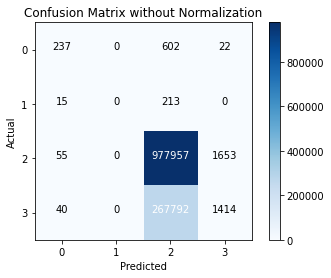

In [23]:
import itertools
plt.imshow(cm,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix without Normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(y_tt))) # length of classes
class_labels = ['0','1','2','3']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cm.max() / 4.
for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],'d'),horizontalalignment='center',color='white' if cm[i,j] >thresh else 'black')
plt.show();

In [26]:
acc = metrics.accuracy_score(y_tt, predictions)
recall = metrics.recall_score(y_tt, predictions, average='weighted')
f1 = metrics.f1_score(y_tt, predictions, average='weighted')
prec = metrics.precision_score(y_tt, predictions, average='weighted')
print("Following are the details of model evaluations:")
print("Accuracy is", acc*100)
print("Recall is", recall*100)
print("F1-Score is", f1*100)
print("Precision is", prec*100)

Following are the details of model evaluations:
Accuracy is 78.36864
Recall is 78.36864
F1-Score is 69.10760641089232
Precision is 71.39241183859538


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
import dill
dill.dump_session('phase-II-ml-copy.db')

## Prediction 

In [0]:
import statsmodels.api as sm

In [0]:
y = filtered_data['soh']
X = filtered_data.copy()
X = X.drop(columns=['soh'])


d3 = {'charge': 0, 'drive' : 1, 'storage' : 2}
d4 = {False: 0, True: 1}

X['cycle'] = X['cycle'].map(d3)
X['fast_charge'] = X['fast_charge'].map(d4)

d1 = { 'noBalancing' : 0, 'passiveBalancing' : 1, 'initialValue' : 2}
d2 = {'idle' : 0, 'activeHeating' : 1, 'passingCooling' : 2, 'thermalBalancing' : 3,
      'initialValue' : 4, 'activeCooling' : 5 }


X['thermal_manager_mode'] = X['thermal_manager_mode'].map(d2)
X['balancing_status'] = X['balancing_status'].map(d1)

In [0]:
from sklearn.model_selection import train_test_split
x_tr, x_tt, y_tr, y_tt = train_test_split(X, y, test_size=0.25, random_state=0)

In [0]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(x_tr, y_tr)
predictions = logisticRegr.predict(x_tt)

In [0]:
score = logisticRegr.score(x_tt, y_tt)
print(score)

0.784424


In [0]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_tt, predictions)
print(cm)

[[979111   1643]
 [267827   1419]]


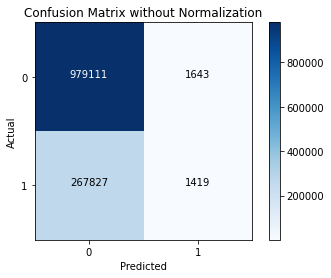

In [0]:
import itertools
plt.imshow(cm,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix without Normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(y_tt))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cm.max() / 2.
for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],'d'),horizontalalignment='center',color='white' if cm[i,j] >thresh else 'black')
plt.show();

In [0]:
acc = metrics.accuracy_score(y_tt, predictions)
recall = metrics.recall_score(y_tt, predictions)
f1 = metrics.f1_score(y_tt, predictions)
prec = metrics.precision_score(y_tt, predictions)
print("Following are the details of model evaluations:")
print("Accuracy is", acc*100)
print("Recall is", recall*100)
print("F1-Score is", f1*100)
print("Precision is", prec*100)

Following are the details of model evaluations:
Accuracy is 78.4424
Recall is 0.5270273281682921
F1-Score is 1.04220221220089
Precision is 46.342259960809926


There are two problems in this:


1.   Process results are not very good, which is mostly because of not comprehensive binning technique applied. That is, the same combination of inputs are resulting Low and the same combination is resulting Medium SOH.
2.   In real world, we wont be getting the values in categories but would be cont. variables. So this method has limitations in that regard as well.